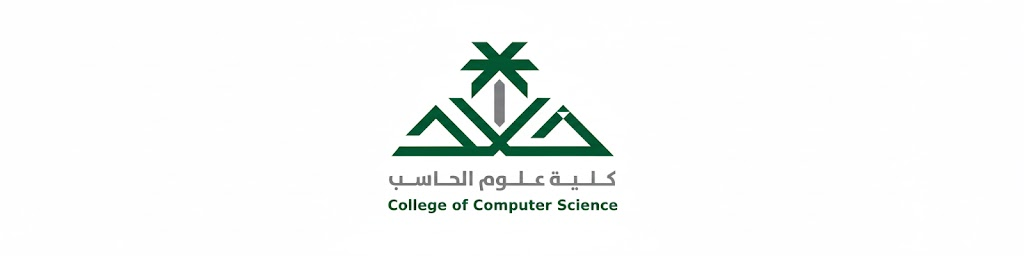



# **🧠Lab 2: Building Your First Neural Network**

This lab will guide us through defining, training, and evaluating a simple Fully Connected Neural Network (FCNN) for a classification task, such as classifying digits from the MNIST dataset.

## What we're going to cover

In this module we're going to cover a standard PyTorch workflow (it can be chopped and changed as necessary but it covers the main outline of steps).

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png" width=900 alt="a pytorch workflow flowchat"/>




Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **1. Building a model** | Here we'll create a model to learn patterns in the data, we'll also choose a **loss function**, **optimizer** and build a **training loop**. |
| **2. Fitting the model to data (training)** | We've got data and a model, now let's let the model (try to) find patterns in the (**training**) data. |
| **3. Making predictions and evaluating a model (inference)** | Our model's found patterns in the data, let's compare its findings to the actual (**testing**) data. |

## 🤖Exercise:

Before we start the exercise, some quick tips:

The lab is going to cover the MNIST dataset which is already available on colab!

For the exercise, we're gonna use the Fashion-MNIST dataset.


The following lines of code can be used to import the Fashion-MNIST dataset:



In [ ]:
###The dataset to be used for the exercise


#train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
#test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

##Few important steps before beginning to make the model:

1-Check out the dataset first

2-Check out the number of samples in the dataset

3-Check if the dataset is already divided into train/eval/test folders

##1. Setup and Data Loading

Let's import what we'll need for this module.

We're going to get `torch`, `torch.nn` (`nn` stands for neural network and this package contains the building blocks for creating neural networks in PyTorch) and `matplotlib`.

### PyTorch model building essentials

PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

They are [`torch.nn`](https://pytorch.org/docs/stable/nn.html), [`torch.optim`](https://pytorch.org/docs/stable/optim.html), [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html).


| PyTorch Module | Role | Key Functionality |
| :--- | :--- | :--- |
| `torch.nn` | **Model Architecture & Layers** | Provides all building blocks for defining the neural network (e.g., layers like `nn.Linear`, activation functions like `nn.ReLU`, and base class **`nn.Module`**). |
| `torch.optim` | **Optimization & Learning** | Implements various **optimization algorithms** (e.g., `optim.SGD`, `optim.Adam`) which calculate how to update model parameters (`nn.Parameters`) based on the calculated loss and gradients. |
| `torch.utils.data.Dataset` | **Data Representation** | An abstract class used to **store samples** and their corresponding labels. You subclass this to define *how* to access your raw data (e.g., loading an image from a file path). |
| `torch.utils.data.DataLoader` | **Data Loading & Batching** | Wraps a `Dataset` and provides an **iterable** over the data. It handles crucial logistics like **batching** (grouping samples), shuffling, and parallel data loading (using multiple workers). |


Almost everything in a PyTorch neural network comes from `torch.nn`,
* `nn.Module` contains the larger building blocks (layers)
* `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make `nn.Module`(s))
* `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within  `nn.Module`(s)
* `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data


> **Resource:** See more of these essential modules and their use cases in the [PyTorch Cheat Sheet](https://pytorch.org/tutorials/beginner/ptcheat.html).


In [ ]:
# CODE CELL 1: Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Split data into training and test sets

We've got some data.

But before we build a model we need to split it up.

One of most important steps in a machine learning project is creating a training and test set (and when required, a validation set).

Each split of the dataset serves a specific purpose:

| Split | Purpose | Amount of total data | How often is it used? |
| ----- | ----- | ----- | ----- |
| **Training set** | The model learns from this data (like the course materials you study during the semester). | ~60-80% | Always |
| **Validation set** | The model gets tuned on this data (like the practice exam you take before the final exam). | ~10-20% | Often but not always |
| **Testing set** | The model gets evaluated on this data to test what it has learned (like the final exam you take at the end of the semester). | ~10-20% | Always |

For now, we'll just use a training and test set, this means we'll have a dataset for our model to learn on as well as be evaluated on.

We can create them by splitting our `X` and `y` tensors.

> **Note:** When dealing with real-world data, this step is typically done right at the start of a project (the test set should always be kept separate from all other data). We want our model to learn from training data and then evaluate it on test data to get an indication of how well it **generalizes** to unseen examples.


##🖼️ Intro to PyTorch torchvision.transforms
The torchvision.transforms module provides common image transformations that can be chained together using transforms.Compose. These transformations are essential for preparing image data for training a neural network, handling everything from data augmentation to tensor conversion and normalization.

| **Category**        | Transformation                  | Function / Parameters   | Description |
|---------------------|----------------------------------|--------------------------|-------------|
| **Conversion**      | `transforms.ToTensor()`          | N/A                      | Converts a PIL Image or NumPy array into a PyTorch `FloatTensor` (channel × height × width) and automatically scales pixel values from the `[0, 255]` integer range to the `[0.0, 1.0]` float range. |
| **Conversion**      | `transforms.ToPILImage()`        | N/A                      | Converts a PyTorch tensor back into a PIL Image. |
| **Normalization**   | `transforms.Normalize()`         | `mean`, `std`            | Normalizes a tensor image using the formula: `(input - mean) / std`. This standardizes the data for better model convergence. |
| **Normalization**   | `transforms.Resize()`            | size (int or tuple)      | Resizes the input image to the given size. If size is an integer, the smaller edge is matched to this size while maintaining the aspect ratio. |
| **Resizing**        | `transforms.CenterCrop()`        | size (int or tuple)      | Crops the image centrally to the desired size. |
| **Resizing**        | `transforms.RandomCrop()`        | size, padding            | Crops the image at a random location. Often used for data augmentation. |
| **Data Augmentation** | `transforms.RandomHorizontalFlip()` | p (probability)      | Flips the image horizontally with a given probability `p`. |
| **Data Augmentation** | `transforms.RandomRotation()`  | degrees (range or value) | Rotates the image randomly by a specified degree range. |
| **Data Augmentation** | `transforms.ColorJitter()`     | brightness, contrast, etc. | Randomly changes the brightness, contrast, saturation, and hue of an image. |
| **Data Augmentation** | `transforms.Grayscale()`       | num_output_channels      | Converts the image to grayscale. |
| **Data Augmentation** | `transforms.RandomErasing()`   | p, scale, ratio          | Randomly selects a rectangular region and erases its pixels. Useful for robustness. |
| **Composition**     | `transforms.Compose()`           | list of transforms       | Chains multiple transformations together in a specific order. This is the standard way to define the full preprocessing pipeline. |


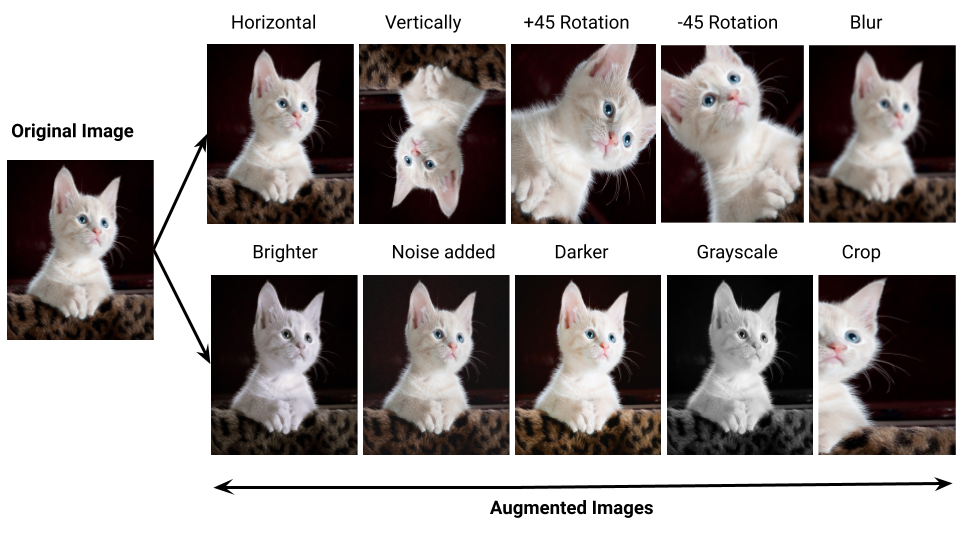

##📦 Intro to PyTorch DataLoader
The torch.utils.data.DataLoader is a crucial component in PyTorch that allows you to efficiently load, batch, shuffle, and manage your data during the training and evaluation phases. It abstracts away the complexity of iterating over the dataset.

Here is a guide to the key parameters of the DataLoader constructor in a tabular format:

| **Parameter**   | Type        | Default Value | Description |
|-----------------|-------------|----------------|-------------|
| **dataset**     | Dataset     | (Required)     | The Dataset object from which to load the data (e.g., an instance of `torch.utils.data.Dataset` or `torchvision.datasets`). |
| **batch_size**  | int         | 1              | Number of samples processed in a single batch. Crucial for optimization efficiency. |
| **shuffle**     | bool        | False          | If True, data is randomly shuffled every epoch. Standard for training to avoid learning a fixed data order. |
| **sampler**     | Sampler     | None           | Strategy to draw samples from the Dataset. Overrides `shuffle`. Useful for weighted or distributed sampling. |
| **num_workers** | int         | 0              | Number of subprocesses used for data loading. Higher values enable parallel loading for faster training. |
| **collate_fn**  | Callable    | None           | Function to merge a list of samples into a mini-batch. Essential for variable-sized data (e.g., text, graphs). |
| **pin_memory**  | bool        | False          | If True, tensors are copied into CUDA pinned memory for faster transfer to GPU. Especially useful when `num_workers > 0`. |
| **drop_last**   | bool        | False          | If True, drops the final incomplete batch. Helpful when consistent batch size is required during training. |
| **timeout**     | numeric     | 0              | Time limit (seconds) for collecting a batch from worker processes. |


In [ ]:
# CODE CELL 2: Data Preprocessing and Loading
# 1. Define a transformation to convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Standard normalization for MNIST
])

# 2. Download and load the training and testing datasets
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# 3. Create DataLoaders for batch processing
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 548kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.86MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.7MB/s]

Number of training batches: 938


## 2. Defining the Model Architecture

The core of the lab is defining the neural network using nn.Module. For a fully connected network on MNIST, we must first flatten the $28 \times 28$ image into a $784$-dimensional vector.

### Step 1. Defining the Model Class (nn.Module)
Every PyTorch neural network must inherit from torch.nn.Module. This class provides the fundamental framework for training (like tracking parameters and children modules).

---

| **Component**                           | Purpose                                                                 | Customization Notes |
|-----------------------------------------|---------------------------------------------------------------------------|----------------------|
| **class MyModel(nn.Module):**           | Standard class definition for a neural network model.                    | Name clearly based on purpose (e.g., `ResNetBlock`, `SimpleClassifier`). |
| **def __init__(self, ...):**            | Constructor where layers and model components are created.                | Define ALL layers here. Never define layers inside `forward()`. |
| **super(MyModel, self).__init__():**    | Initializes the base `nn.Module` class (required).                        | Must be the **first line** inside `__init__`. |


---


### Step 2. The Model Layers and Components ( the __init__ function)

<img src="https://editor.analyticsvidhya.com/uploads/90650dnn2.jpeg" width=900 alt="a pytorch workflow flowchat"/>


| **Component Type**            | PyTorch Class                          | Example (for MNIST)                                               | Customization / Tuning Notes |
|-------------------------------|-----------------------------------------|-------------------------------------------------------------------|-------------------------------|
| **Fully Connected Layer**     | `nn.Linear`                             | `self.fc1 = nn.Linear(input_size, hidden_size)`                   | Tune `in_features`, `out_features`. `hidden_size` controls model capacity. |
| **Activation Function**       | `nn.ReLU`, `nn.Sigmoid`, `nn.Tanh`      | `self.relu = nn.ReLU()`                                           | ReLU is default. Sigmoid/Tanh for special cases (GANs, RNNs). |
| **Convolutional Layer**       | `nn.Conv2d`                             | `self.conv1 = nn.Conv2d(1, 32, kernel_size=3)`                    | Tune `in_channels`, `out_channels`, `kernel_size`, `stride`, `padding`. |
| **Pooling Layer**             | `nn.MaxPool2d`                          | `self.pool = nn.MaxPool2d(kernel_size=2)`                         | Reduces spatial dimensions. Tune `kernel_size`, `stride`. |
| **Normalization Layer**       | `nn.BatchNorm1d`, `nn.BatchNorm2d`      | `self.bn = nn.BatchNorm1d(hidden_size)`                            | Stabilizes training. Choose 1D or 2D based on layer type. |
| **Dropout**                   | `nn.Dropout`                            | `self.dropout = nn.Dropout(p=0.5)`                                 | Use during training to reduce overfitting. Tune probability `p`. |


### Step 3. The Forward Pass

The forward() method defines the computational flow or path that data takes through the layers defined in __init__.


| **Step**                   | Example Code (from SimpleClassifier)      | Purpose and Customization |
|----------------------------|--------------------------------------------|----------------------------|
| **Input Shape Handling**   | `x = x.view(x.size(0), -1)`               | Reshapes the input tensor to match layer requirements. For MNIST, flattens `N × 1 × 28 × 28` into `N × 784`. |
| **Sequential Layer Flow**  | `out = self.fc1(x)`                       | Applies the first linear transformation (feature projection). |
| **Activation**             | `out = self.relu(out)`                    | Adds non-linearity, enabling learning of complex mappings. |
| **Chaining Layers**        | `out = self.fc2(out)`                     | Final layer. Output size must match `NUM_CLASSES` in a classifier. |
| **Return**                 | `return out`                               | Returns logits (raw scores). Softmax is usually applied inside the loss function, so it isn't added here. |


###🛠️ How to Choose Parameters for Any Architecture
When building a new class (like a Convolutional Neural Network or a Transformer), look at the layers you're defining in __init__ and ask:

| **Question to Ask**                                     | PyTorch Layer Parameter                 | Suggested __init__ Parameter           |
|----------------------------------------------------------|------------------------------------------|----------------------------------------|
| **What is the first layer expecting?**                  | `in_features` (Linear), `in_channels` (Conv) | `input_size`, `input_channels`          |
| **How many neurons/channels should the internal layers have?** | `out_features`, `out_channels`          | `hidden_dim`, `num_filters`             |
| **What is the required final output size?**             | `out_features` (final layer)             | `num_classes`, `output_dim`             |
| **Are there tunable components?**                       | dropout probability, kernel_size, number of blocks | `dropout_p`, `kernel_size`, `num_layers` |


---

In [ ]:
# CODE CELL 3: Define the Neural Network
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleClassifier, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(input_size, hidden_size)  # First fully connected layer
        self.relu = nn.ReLU()                         # Activation function
        self.fc2 = nn.Linear(hidden_size, num_classes) # Output layer

    def forward(self, x):
        # The input 'x' is a batch of images (e.g., [64, 1, 28, 28])

        # 1. Flatten the image: (batch_size, 1*28*28) -> (batch_size, 784)
        x = x.view(x.size(0), -1)

        # 2. Pass through the layers
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)

        # We don't apply softmax here; it's usually included in nn.CrossEntropyLoss
        return out

# Model Hyperparameters
INPUT_SIZE = 28 * 28  # 784
HIDDEN_SIZE = 128     # A common choice for a hidden layer
NUM_CLASSES = 10      # Digits 0-9

# Instantiate the model and move it to the device
model = SimpleClassifier(INPUT_SIZE, HIDDEN_SIZE, NUM_CLASSES).to(device)

print(model)

SimpleClassifier(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### **Loss Function: nn.CrossEntropyLoss()**

- frequently used in multi-class classification

It combines two critical steps into a single, numerically stable operation:

- Softmax Activation: It applies the $\text{Softmax}$ function to the model's raw output (logits) to convert them into a set of normalized probabilities that sum to 1.

- Negative Log Likelihood (NLL) Loss: It then calculates the loss based on the negative logarithm of the predicted probability for the correct class (the target).

In [ ]:
# CODE CELL 4: Define Loss and Optimizer
# 1. Loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# 2. Optimizer (Stochastic Gradient Descent is a classic choice)
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

##3. Loss Function and Optimizer



### PyTorch testing loop

As for the testing loop (evaluating our model), the typical steps include:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the testing data once, performing its `forward()` function calculations. | `model(x_test)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_test)` |
| 3 | Calulate evaluation metrics (optional) | Alongside the loss value you may want to calculate other evaluation metrics such as accuracy on the test set. | Custom functions |

Notice the testing loop doesn't contain performing backpropagation (`loss.backward()`) or stepping the optimizer (`optimizer.step()`), this is because no parameters in the model are being changed during testing, they've already been calculated. For testing, we're only interested in the output of the forward pass through the model.



## 4. Training Loop

This is where the model learns by iterating over the data multiple times (epochs).

| Feature           | `model.train()`                           | `model.eval()`                             |
|------------------|------------------------------------------|-------------------------------------------|
| Purpose           | Sets training mode                        | Sets evaluation mode                       |
| Dropout           | Enabled (randomly zeroes neurons)        | Disabled (all neurons active)             |
| Batch Norm        | Uses mini-batch stats; updates running stats | Uses running stats; no updates           |
| Gradients         | Computes gradients (`loss.backward()`)    | No gradients (`with torch.no_grad():`)    |


In [ ]:
# CODE CELL 5 (MODIFIED): Training and Tracking ALL Metrics
import time

# History lists for all four metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
NUM_EPOCHS = 5

start_time = time.time()

for epoch in range(NUM_EPOCHS):

    # --- 1. Training Phase ---
    model.train()

    epoch_train_loss = 0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):

      '''1. Batch Index Tracking
      enumerate(train_loader) wraps the data loader and starts counting from zero.
      For each iteration of the loop (i.e., for each batch),
      enumerate returns two things:
      a)i (the Index/Counter): This variable holds the zero-based index of the current batch.
      If your batch_size is 64, when i=0, you get the first 64 samples;
      when i=1, you get the next 64 samples, and so on.

      b)(images, labels) (the Data): This holds the actual batch of data yielded by the train_loader.
        '''
        images, labels = images.to(device), labels.to(device)

        # Forward pass, Loss, Backward, and Optimize
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        #Resets the gradients of all model parameters to zero to prevent accumulation from previous iterations.

        loss.backward()
        #Computes the gradients of the loss with respect to all trainable parameters using the chain rule (backpropagation).

        optimizer.step()
        #Updates the model's parameters using the calculated gradients and the specific optimization algorithm (e.g., SGD, Adam).

        # Track training loss and accuracy for plotting
        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate average metrics for the epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_acc = 100 * correct_train / total_train
    train_accuracies.append(train_acc)


    # --- 2. Evaluation Phase (Test/Validation) ---
    model.eval()
    epoch_test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels) # Calculate test loss

            epoch_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    # Calculate average metrics for the test set
    avg_test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    test_acc = 100 * correct_test / total_test
    test_accuracies.append(test_acc)

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.2f} %')

end_time = time.time()
print(f"\nTraining finished in {(end_time - start_time):.2f} seconds.")

Epoch [1/5] | Train Loss: 0.1195 | Test Loss: 0.1212 | Test Acc: 96.38 %
Epoch [2/5] | Train Loss: 0.1119 | Test Loss: 0.1159 | Test Acc: 96.39 %
Epoch [3/5] | Train Loss: 0.1052 | Test Loss: 0.1122 | Test Acc: 96.67 %
Epoch [4/5] | Train Loss: 0.0994 | Test Loss: 0.1071 | Test Acc: 96.76 %
Epoch [5/5] | Train Loss: 0.0940 | Test Loss: 0.1031 | Test Acc: 96.95 %

Training finished in 77.66 seconds.


![pytorch annotated testing loop](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-testing-loop-annotated.png)



## 5. Evaluation
Finally, assess the model's performance on the held-out test data.

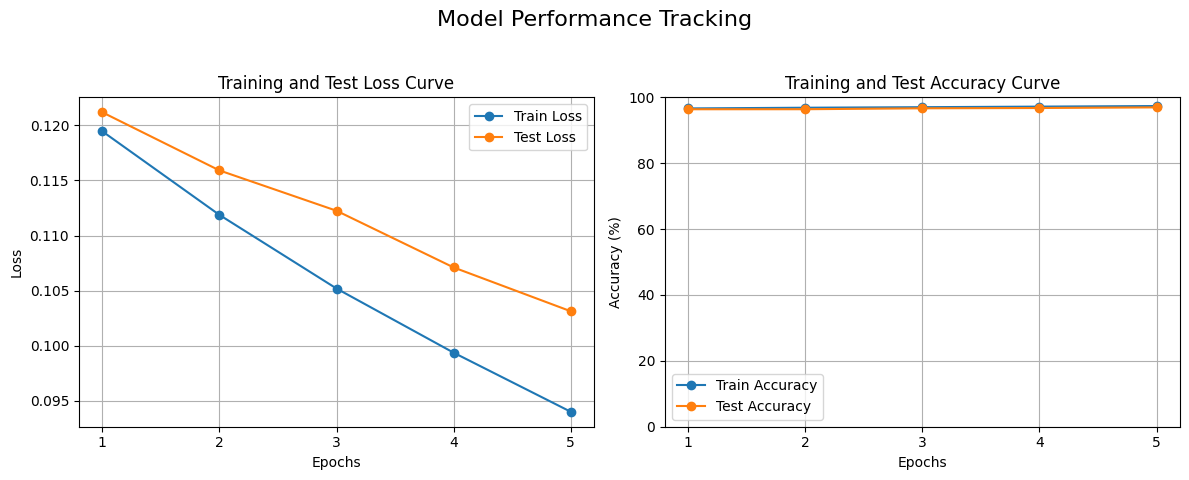

In [ ]:
# CODE CELL 6: Plotting Training History
import matplotlib.pyplot as plt

# The number of epochs used in the training loop
num_epochs = NUM_EPOCHS

plt.figure(figsize=(12, 5))

# --- Plot 1: Loss Curve ---
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), test_losses, label="Test Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss Curve")
plt.xticks(range(1, num_epochs+1))
plt.legend()
plt.grid(True)

# --- Plot 2: Accuracy Curve ---
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), test_accuracies, label="Test Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Test Accuracy Curve")
plt.xticks(range(1, num_epochs+1))
plt.ylim(0, 100) # Keep the accuracy plot scaled properly
plt.legend()
plt.grid(True)

plt.suptitle("Model Performance Tracking", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##Your turn Noww:

First, take the fashion-MNIST dataset(the code to access the data is given in the beginning of the lab)

Play around with the learning rate, the optimizer, the loss function(be careful here!!)

Also, try to change the models and try VGG

## -Lab made by Hasan Kamal